In [242]:
import pandas as pd
import numpy as np
import spacy

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.preprocessing import sequence

In [218]:
from datasets import load_dataset

dataset = load_dataset("shahxeebhassan/human_vs_ai_sentences")

for k in dataset.keys():
    dataset[k].to_csv(f'../data/{k}_human_vs_ai_sentences.csv', index = False)

Creating CSV from Arrow format: 100%|██████████| 105/105 [00:00<00:00, 136.53ba/s]



    0: Human-written
    1: AI-generated


In [219]:
df = pd.read_csv("../data/train_human_vs_ai_sentences.csv")
df.head(5)

,text,label
0,Another reason why all students should have to...,0
1,Also the Electoral College consists of 538 ele...,0
2,Many countries have made changes in there town...,0
3,I believe the process of choosing a president ...,0
4,A thick cloud of carbon dioxide and heats to h...,0


In [220]:
df['text_len'] = df['text'].str.len()
df['word_count'] = df['text'].str.split(" ").str.len()

length_stats = df.groupby('label')[['text_len', 'word_count']].agg(['mean', 'median', 'std']).round(2)
print(length_stats)

      text_len               word_count              
          mean median    std       mean median    std
label                                                
0       113.69  100.0  71.72      20.55   18.0  13.09
1       118.10  110.0  63.50      19.31   18.0   9.57


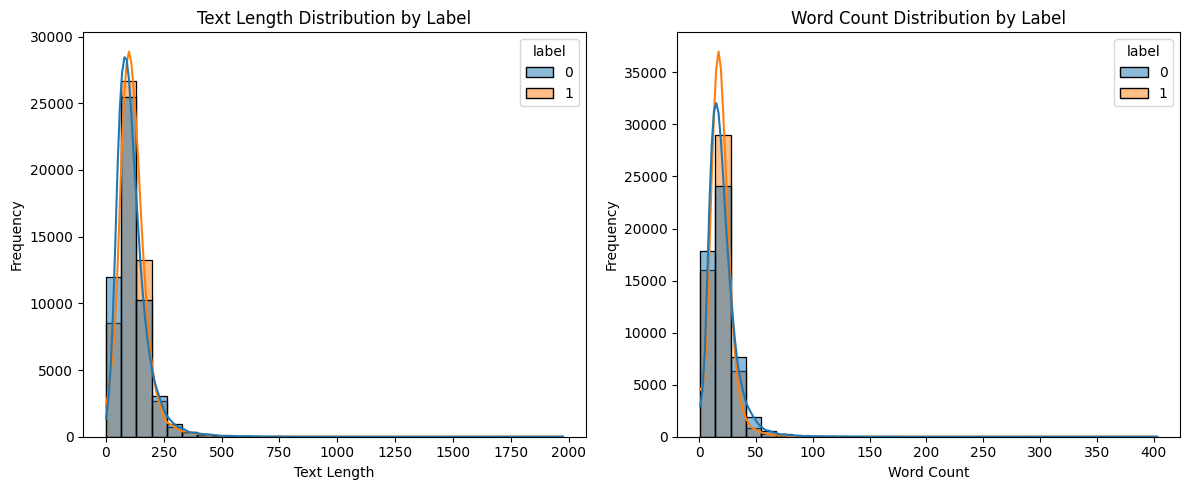

In [221]:


plt.figure(figsize=(12, 5))

# Text length distribution by label
plt.subplot(1, 2, 1)
sns.histplot(data=df, x='text_len', hue='label', bins=30, kde=True)
plt.title('Text Length Distribution by Label')
plt.xlabel('Text Length')
plt.ylabel('Frequency')

# Word count distribution by label
plt.subplot(1, 2, 2)
sns.histplot(data=df, x='word_count', hue='label', bins=30, kde=True)
plt.title('Word Count Distribution by Label')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [222]:
print(f"Human texts: {(df['label'] == 0).sum()}")
print(f"AI texts: {(df['label'] == 1).sum()}")

Human texts: 52500
AI texts: 52500


## Analysis

In [223]:
#Sample
df = df.sample(10000, random_state=0)

In [224]:
nlp = spacy.load("en_core_web_sm")

rows = []

for _, row in df.iterrows():
    doc = nlp(row.text)

    rows.append({
        "vector": doc.vector,
        "symbol_count": len(row.text),
        "token_count": len(doc),
        "token_len": len(row.text)/len(doc),
        "sentence_count": len(list(doc.sents)),
        "unique_tokens_count": len(set([t.text for t in doc if not t.is_punct])),
        "comma_density": row.text.count(',') / max(len(row.text), 1) * 1000,
        "period_density": row.text.count('.') / max(len(row.text), 1) * 1000
    })

f_df = pd.DataFrame(rows)
f_df = pd.concat([df['label'].reset_index(drop=True), f_df.reset_index(drop=True)], axis=1)


In [225]:
f_df

,label,vector,symbol_count,token_count,token_len,sentence_count,unique_tokens_count,comma_density,period_density
0,1,"[-0.37548882, -0.27621207, -0.10975007, -0.134...",71,14,5.071429,1,12,0.000000,14.084507
1,0,"[-0.2696849, -0.13236189, 0.08262889, -0.01146...",178,36,4.944444,1,23,16.853933,5.617978
2,1,"[0.009406307, -0.32786164, 0.051851757, -0.101...",183,33,5.545455,1,26,5.464481,5.464481
3,0,"[0.2291652, 0.4451469, -0.24918771, -1.2330818...",18,3,6.000000,1,2,0.000000,55.555556
4,1,"[-0.28644896, -0.39041477, 0.40360314, -0.1074...",43,13,3.307692,1,10,46.511628,0.000000
...,...,...,...,...,...,...,...,...,...
9995,1,"[0.19264492, -0.2870953, 0.15072444, 0.1264851...",102,23,4.434783,1,18,9.803922,0.000000
9996,1,"[-0.25524887, -0.4190306, 0.25458327, -0.14346...",69,17,4.058824,1,16,0.000000,14.492754
9997,0,"[-0.43663687, -0.48110798, 0.5521626, -0.01338...",250,61,4.098361,1,34,4.000000,4.000000
9998,0,"[-0.30400282, 0.0024729446, -0.1280509, -0.048...",51,12,4.250000,1,9,39.215686,19.607843


In [226]:
f_df.columns

Index(['label', 'vector', 'symbol_count', 'token_count', 'token_len',
       'sentence_count', 'unique_tokens_count', 'comma_density',
       'period_density'],
      dtype='object')

In [227]:
f_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   label                10000 non-null  int64  
 1   vector               10000 non-null  object 
 2   symbol_count         10000 non-null  int64  
 3   token_count          10000 non-null  int64  
 4   token_len            10000 non-null  float64
 5   sentence_count       10000 non-null  int64  
 6   unique_tokens_count  10000 non-null  int64  
 7   comma_density        10000 non-null  float64
 8   period_density       10000 non-null  float64
dtypes: float64(3), int64(5), object(1)
memory usage: 703.3+ KB


<Axes: xlabel='token_count', ylabel='Count'>

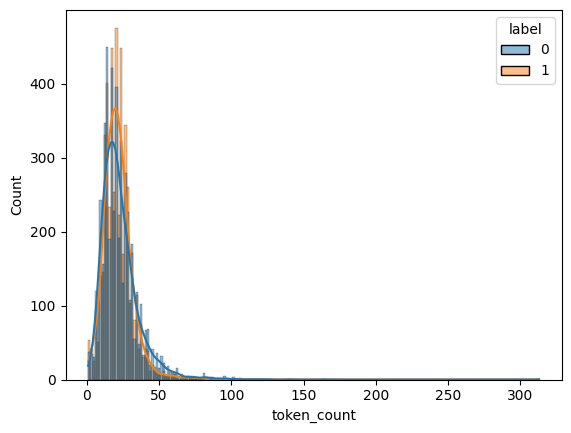

In [228]:
sns.histplot(data=f_df, x='token_count', hue='label', kde=True)

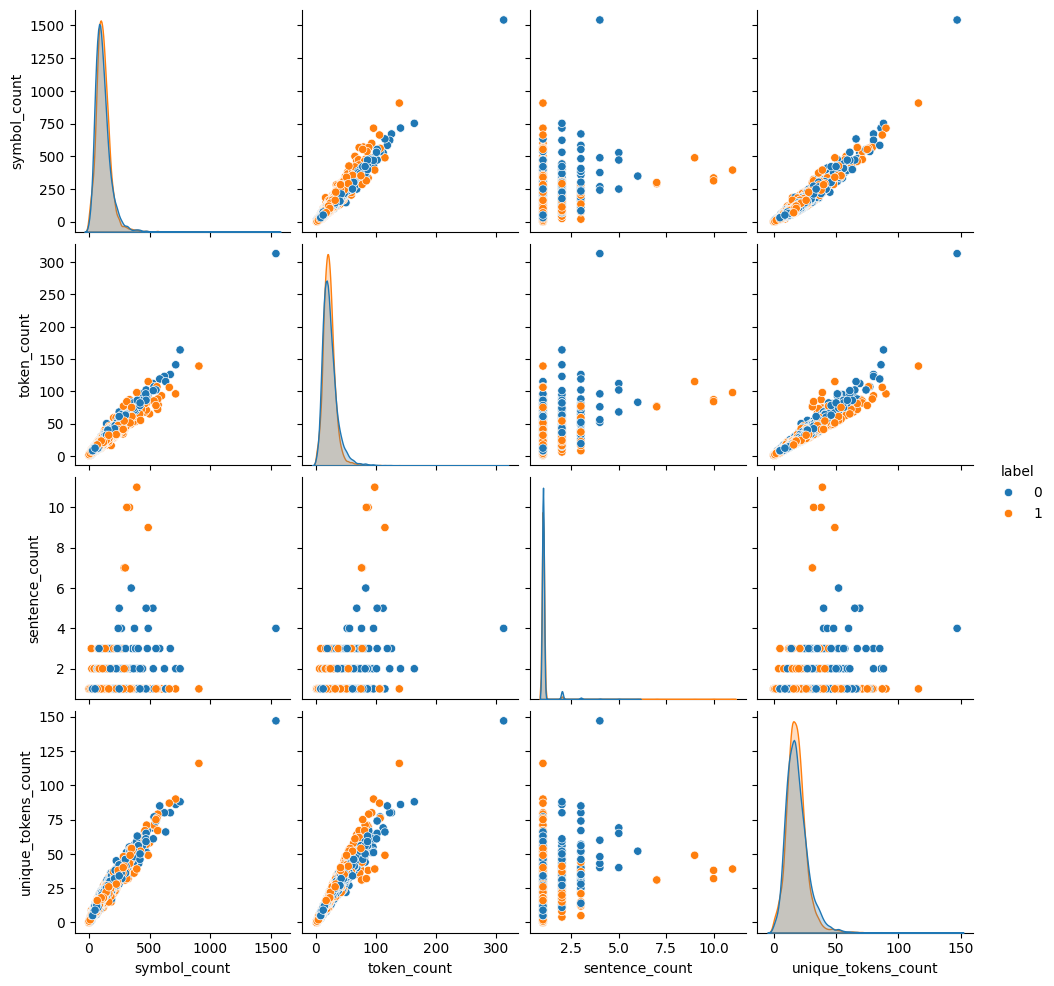

In [229]:
sns.pairplot(f_df.drop('vector', axis=1), hue='label', vars=['symbol_count', 'token_count', 'sentence_count', 'unique_tokens_count'])

# Classifying

In [230]:
x = np.vstack(f_df['vector'].values)
y = f_df['label'].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [257]:
model = Sequential([
    Dense(96, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, batch_size=128, epochs=10, validation_split=0.2)

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6681 - loss: 0.6353 - val_accuracy: 0.7306 - val_loss: 0.5643
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7283 - loss: 0.5482 - val_accuracy: 0.7375 - val_loss: 0.5294
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7508 - loss: 0.5123 - val_accuracy: 0.7400 - val_loss: 0.5224
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7641 - loss: 0.4890 - val_accuracy: 0.7569 - val_loss: 0.4946
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7734 - loss: 0.4726 - val_accuracy: 0.7550 - val_loss: 0.5011
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7917 - loss: 0.4534 - val_accuracy: 0.7569 - val_loss: 0.4982
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8020 - loss: 0.4329 - val_accuracy: 0.7644 - val_loss: 0.4876
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8133 - loss: 0.4156 - val_accuracy: 0.7800 - val_loss:

In [240]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5150 - loss: 0.6929
Test Accuracy: 0.5150


In [241]:
from sklearn.linear_model import LogisticRegression
lreg = LogisticRegression(max_iter=1000)
lreg.fit(x_train, y_train)

from sklearn.svm import SVC
svc = SVC(kernel="rbf", probability=True)
svc.fit(x_train, y_train)

from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=200, random_state=42)
rfc.fit(x_train, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [244]:
y_pred = lreg.predict(x_test)

print("Logistic Regression")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))

Logistic Regression
Accuracy: 0.7545

Classification report:
               precision    recall  f1-score   support

           0       0.74      0.75      0.75       970
           1       0.76      0.76      0.76      1030

    accuracy                           0.75      2000
   macro avg       0.75      0.75      0.75      2000
weighted avg       0.75      0.75      0.75      2000


Confusion matrix:
 [[729 241]
 [250 780]]


In [245]:
y_pred = svc.predict(x_test)

print("SVC")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))

SVC
Accuracy: 0.803

Classification report:
               precision    recall  f1-score   support

           0       0.79      0.80      0.80       970
           1       0.81      0.80      0.81      1030

    accuracy                           0.80      2000
   macro avg       0.80      0.80      0.80      2000
weighted avg       0.80      0.80      0.80      2000


Confusion matrix:
 [[778 192]
 [202 828]]


In [246]:
y_pred = rfc.predict(x_test)

print("Random Forest Classifier")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))

Random Forest Classifier
Accuracy: 0.749

Classification report:
               precision    recall  f1-score   support

           0       0.73      0.76      0.75       970
           1       0.77      0.74      0.75      1030

    accuracy                           0.75      2000
   macro avg       0.75      0.75      0.75      2000
weighted avg       0.75      0.75      0.75      2000


Confusion matrix:
 [[737 233]
 [269 761]]
